In [5]:
import os
import pandas as pd
import numpy as np
import mysql.connector
from dotenv import load_dotenv
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import tukey_hsd
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

OSError: dlopen(/Users/doyoung/Developer/ML/VirtualMachine/estcamp_env/lib/python3.13/site-packages/lightgbm/lib/lib_lightgbm.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib
  Referenced from: <D44045CD-B874-3A27-9A61-F131D99AACE4> /Users/doyoung/Developer/ML/VirtualMachine/estcamp_env/lib/python3.13/site-packages/lightgbm/lib/lib_lightgbm.dylib
  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/local/lib/libomp/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/local/lib/libomp/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file), '/opt/homebrew/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libomp.dylib' (no such file)

In [9]:
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [10]:
# DB Ïó∞Í≤∞
load_dotenv()

conn = mysql.connector.connect(
    host=os.getenv("DB_HOST"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database="suwon_business"
)

cursor = conn.cursor()

In [11]:
# ÏøºÎ¶¨ Ï†ïÏùò
query = """
SELECT
    t.transaction_date,
    t.district_code,
    d.name AS district_name,
    t.time_block_code,
    t.gender,
    t.age_group_code,
    t.day_of_week,
    t.transaction_amount,
    t.transaction_count,
    w.avg_temp
FROM card_transaction t
JOIN district d ON t.district_code = d.district_id
JOIN weather w ON t.transaction_date = w.weather_date AND t.district_code = w.district_id
"""

df = pd.read_sql(query, conn)
conn.close()

print(df.head())

/var/folders/36/pdpmp_4s2wv687klck6zglrm0000gn/T/ipykernel_58242/3308682761.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


  transaction_date  district_code district_name  time_block_code gender  \
0       2024-08-01          41111           Ïû•ÏïàÍµ¨                1      F   
1       2024-08-01          41111           Ïû•ÏïàÍµ¨                1      M   
2       2024-08-01          41111           Ïû•ÏïàÍµ¨                1      M   
3       2024-08-01          41111           Ïû•ÏïàÍµ¨                1      M   
4       2024-08-01          41111           Ïû•ÏïàÍµ¨                1      M   

   age_group_code  day_of_week  transaction_amount  transaction_count  \
0               3            4               19556                  3   
1               2            4                4010                  2   
2               3            4               14393                  3   
3               4            4                 876                  2   
4               5            4                 939                  2   

   avg_temp  
0    29.229  
1    29.229  
2    29.229  
3    29.229  
4    29.22

In [8]:
df.columns

Index(['transaction_date', 'district_code', 'district_name', 'time_block_code',
       'gender', 'age_group_code', 'day_of_week', 'transaction_amount',
       'transaction_count', 'avg_temp'],
      dtype='object')

In [9]:
df.count()

transaction_date      1603322
district_code         1603322
district_name         1603322
time_block_code       1603322
gender                1603322
age_group_code        1603322
day_of_week           1603322
transaction_amount    1603322
transaction_count     1603322
avg_temp              1603322
dtype: int64

In [10]:
df.info

<bound method DataFrame.info of         transaction_date  district_code district_name  time_block_code gender  \
0             2024-08-01          41111           Ïû•ÏïàÍµ¨                1      F   
1             2024-08-01          41111           Ïû•ÏïàÍµ¨                1      M   
2             2024-08-01          41111           Ïû•ÏïàÍµ¨                1      M   
3             2024-08-01          41111           Ïû•ÏïàÍµ¨                1      M   
4             2024-08-01          41111           Ïû•ÏïàÍµ¨                1      M   
...                  ...            ...           ...              ...    ...   
1603317       2025-03-31          41117           ÏòÅÌÜµÍµ¨               10      F   
1603318       2025-03-31          41117           ÏòÅÌÜµÍµ¨               10      F   
1603319       2025-03-31          41117           ÏòÅÌÜµÍµ¨               10      M   
1603320       2025-03-31          41117           ÏòÅÌÜµÍµ¨               10      M   
1603321       2025-03-3

In [11]:
df.isnull().mean().sort_values(ascending=False)

transaction_date      0.0
district_code         0.0
district_name         0.0
time_block_code       0.0
gender                0.0
age_group_code        0.0
day_of_week           0.0
transaction_amount    0.0
transaction_count     0.0
avg_temp              0.0
dtype: float64

In [12]:
df.describe()

district_code  time_block_code  age_group_code   day_of_week  \
count   1.603322e+06     1.603322e+06    1.603322e+06  1.603322e+06   
mean    4.111411e+04     5.464615e+00    5.050107e+00  3.999974e+00   
std     2.268238e+00     2.490763e+00    1.803883e+00  1.995954e+00   
min     4.111100e+04     1.000000e+00    1.000000e+00  1.000000e+00   
25%     4.111300e+04     3.000000e+00    4.000000e+00  2.000000e+00   
50%     4.111500e+04     5.000000e+00    5.000000e+00  4.000000e+00   
75%     4.111700e+04     8.000000e+00    6.000000e+00  6.000000e+00   
max     4.111700e+04     1.000000e+01    1.100000e+01  7.000000e+00   

       transaction_amount  transaction_count      avg_temp  
count        1.603322e+06       1.603322e+06  1.603322e+06  
mean         1.773111e+05       1.976734e+01  1.407041e+01  
std          4.587060e+05       3.464352e+01  1.073996e+01  
min          0.000000e+00       2.000000e+00 -1.024200e+01  
25%          1.595700e+04       3.000000e+00  3.514100e+00  
50%          5.194000e+04       8.000000e+00  1.584370e+01  
75%          1.595068e+05       2.000000e+01  2.359820e+01  
max          5.460398e+07       1.009000e+03  3.020880e+01

In [35]:
df.shape

(1603322, 10)

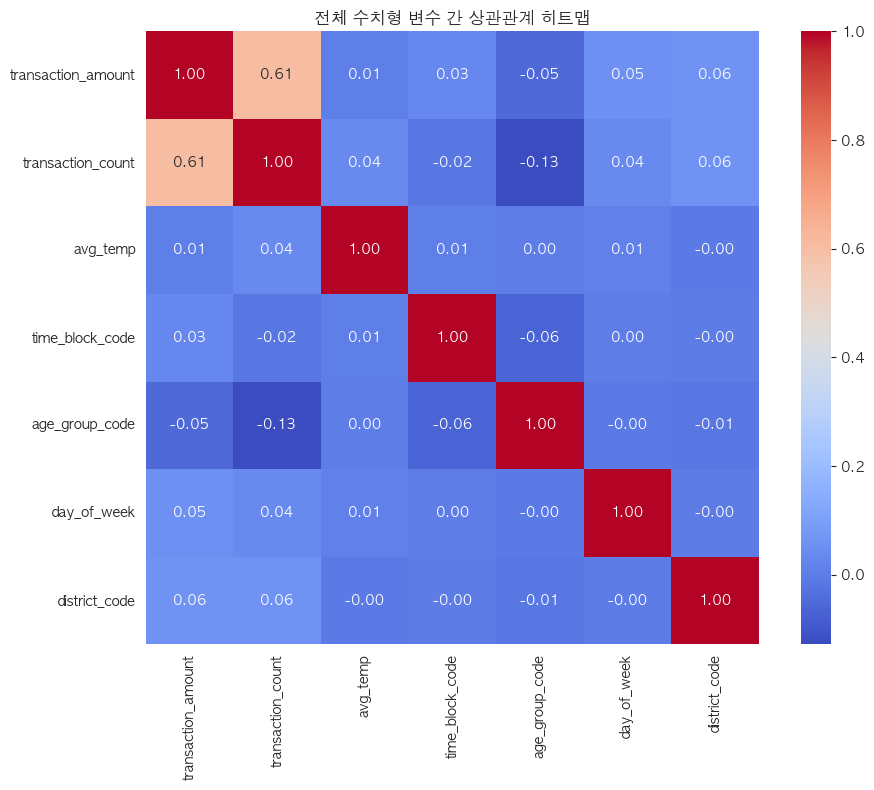

In [13]:
# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù ÎåÄÏÉÅ ÏàòÏπòÌòï Ïª¨ÎüºÎßå ÏÑ†ÌÉù
numeric_cols = [
    'transaction_amount', 'transaction_count',
    'avg_temp',
    'time_block_code', 'age_group_code',
    'day_of_week', 'district_code'
]

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú Ïà´ÏûêÌòï Ïó¥ Ï∂îÏ∂ú
corr_df = df[numeric_cols]

# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌñâÎ†¨ Í≥ÑÏÇ∞
corr_matrix = corr_df.corr()

# ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Ï†ÑÏ≤¥ ÏàòÏπòÌòï Î≥ÄÏàò Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ")
plt.tight_layout()
plt.show()

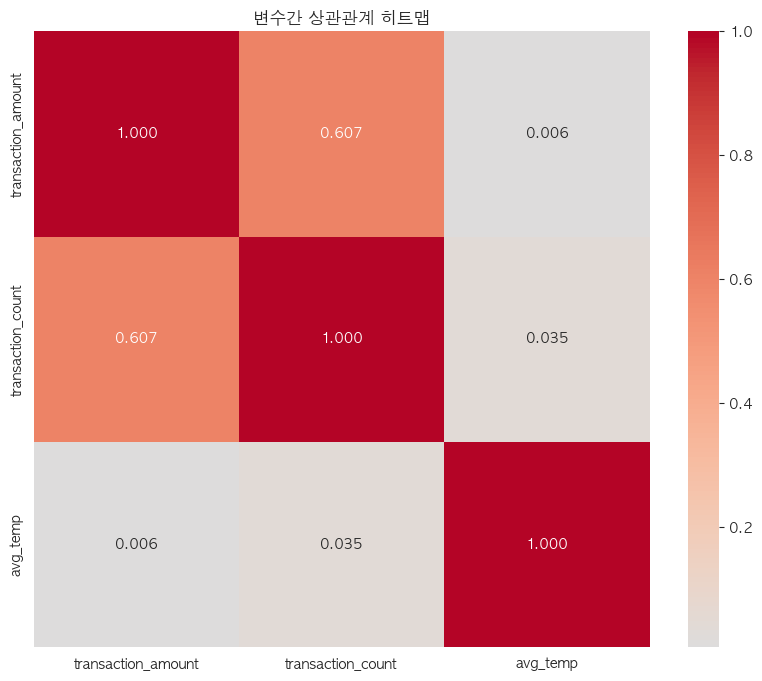

üìà ÌÜµÍ≥ÑÏ†Å Ïú†ÏùòÏÑ± Í≤ÄÏ†ï
ÌèâÍ∑†Í∏∞Ïò®-Îß§Ï∂ú ÏÉÅÍ¥ÄÍ≥ÑÏàò: 0.0064 (p-value: 0.000000)
ÌèâÍ∑†Í∏∞Ïò®-Í±∞ÎûòÍ±¥Ïàò ÏÉÅÍ¥ÄÍ≥ÑÏàò: 0.0351 (p-value: 0.000000)



In [38]:
# ÏÉÅÍ¥ÄÍ≥ÑÏàò Í≥ÑÏÇ∞
correlation_vars = ['transaction_amount', 'transaction_count', 'avg_temp']
correlation_matrix = df[correlation_vars].corr()

# ÏÉÅÍ¥ÄÍ≥ÑÏàò ÌûàÌä∏Îßµ
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Î≥ÄÏàòÍ∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ')
plt.show()


# ÌÜµÍ≥ÑÏ†Å Ïú†ÏùòÏÑ± Í≤ÄÏ†ï
print("üìà ÌÜµÍ≥ÑÏ†Å Ïú†ÏùòÏÑ± Í≤ÄÏ†ï")
temp_amount_corr, temp_amount_p = stats.pearsonr(df['avg_temp'], df['transaction_amount'])
print(f"ÌèâÍ∑†Í∏∞Ïò®-Îß§Ï∂ú ÏÉÅÍ¥ÄÍ≥ÑÏàò: {temp_amount_corr:.4f} (p-value: {temp_amount_p:.6f})")

temp_count_corr, temp_count_p = stats.pearsonr(df['avg_temp'], df['transaction_count'])
print(f"ÌèâÍ∑†Í∏∞Ïò®-Í±∞ÎûòÍ±¥Ïàò ÏÉÅÍ¥ÄÍ≥ÑÏàò: {temp_count_corr:.4f} (p-value: {temp_count_p:.6f})")

In [32]:
X = df[['avg_temp', 'time_block_code', 'gender', 'age_group_code', 'day_of_week', 'district_code']]
y = df['transaction_amount']

categorical_features = ['gender', 'district_code']
numeric_features = ['avg_temp', 'time_block_code', 'age_group_code', 'day_of_week']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Î™®Îç∏ ÌèâÍ∞Ä Í≤∞Í≥º:")
print(f"RMSE: {rmse:.2f}")
print(f"R¬≤ score: {r2:.4f}")

‚úÖ Î™®Îç∏ ÌèâÍ∞Ä Í≤∞Í≥º:
RMSE: 450100.86
R¬≤ score: 0.0148


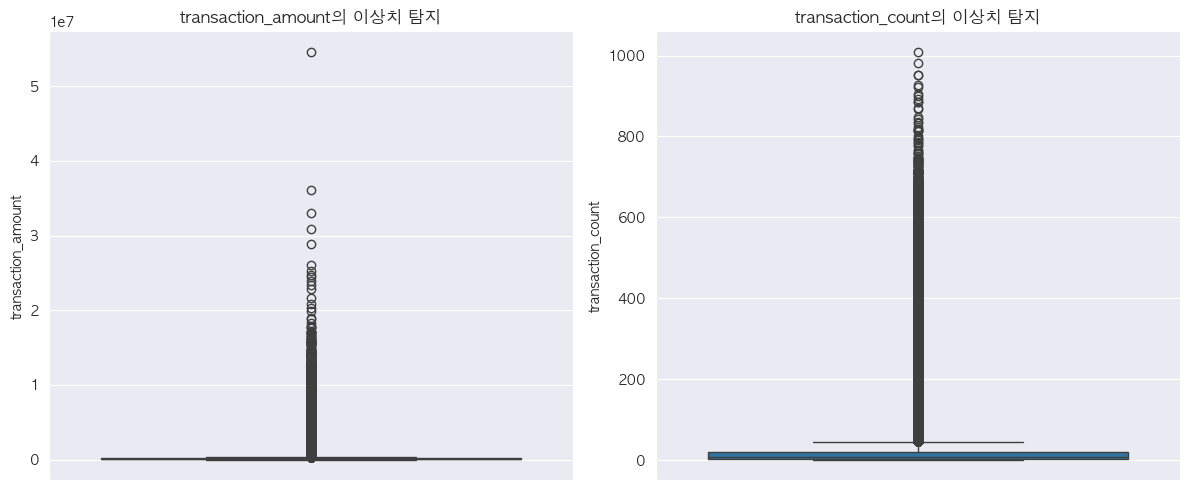

In [31]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(['transaction_amount', 'transaction_count']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'{col}Ïùò Ïù¥ÏÉÅÏπò ÌÉêÏßÄ')
plt.tight_layout()
plt.show()

In [32]:
def remove_outliers_iqr(df, columns):
    mask = pd.Series([True] * len(df))
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask &= df[col].between(lower_bound, upper_bound)
    return df[mask]

In [33]:
target_cols = ['transaction_amount', 'transaction_count']

# Ïù¥ÏÉÅÏπò Ï†úÍ±∞Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
df_no_outliers = remove_outliers_iqr(df, target_cols)

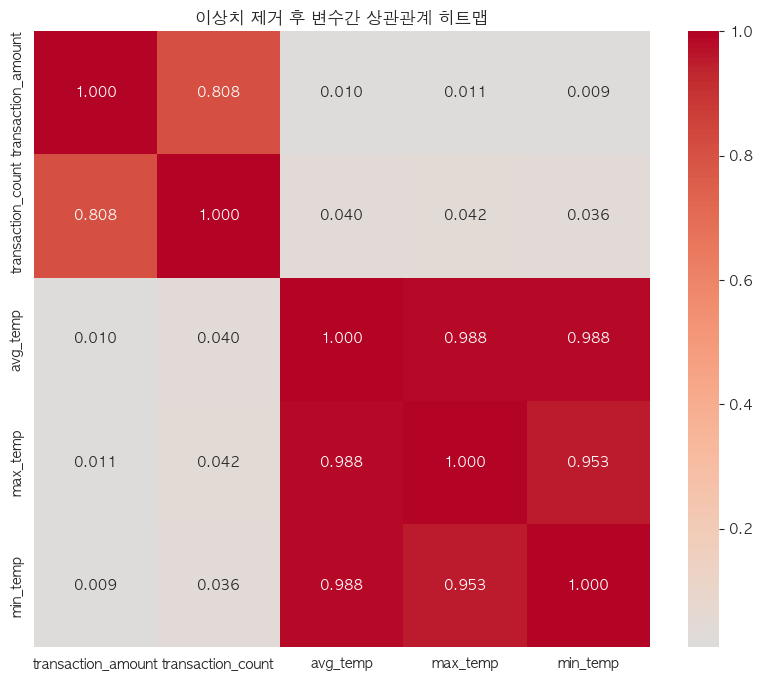

In [36]:
correlation_vars = ['transaction_amount', 'transaction_count',
                    'avg_temp', 'max_temp', 'min_temp']

# ÏÉÅÍ¥ÄÍ≥ÑÏàò Í≥ÑÏÇ∞
correlation_matrix = df_no_outliers[correlation_vars].corr()

# ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑ Î≥ÄÏàòÍ∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ')
plt.show()

In [45]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Í≥†Í∞ù Í∏∞Ï§Ä ÏµúÍ∑º 7Ïùº ÎàÑÏ†Å ÏÜåÎπÑ Í∏àÏï°
df = df.sort_values(by=['gender', 'age_group_code', 'transaction_date'])  # Í≥†Í∞ù proxy: sex + age
df['past_7day_amt'] = df.groupby(['gender', 'age_group_code'])['transaction_amount'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())

# Í≥†Í∞ù Í∏∞Ï§Ä ÏµúÍ∑º 30Ïùº ÎàÑÏ†Å Íµ¨Îß§ ÌöüÏàò
df['past_30day_cnt'] = df.groupby(['gender', 'age_group_code'])['transaction_count'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())

# Í≥†Í∞ùÏùò ÌèâÍ∑† Î∞©Î¨∏Îãπ ÏßÄÏ∂ú Í∏àÏï°
df['mean_amt_per_visit'] = df['transaction_amount'] / (df['transaction_count'] + 1e-5)  # Î∂ÑÎ™® 0 Î∞©ÏßÄ


In [46]:
df.groupby('day_of_week')['transaction_amount'].describe()
df

transaction_date  district_code district_name  time_block_code gender  \
304918        2025-01-20          41111           Ïû•ÏïàÍµ¨                6      F   
763660        2025-02-27          41113           Í∂åÏÑ†Íµ¨                7      F   
97371         2024-04-01          41111           Ïû•ÏïàÍµ¨                1      F   
97377         2024-04-01          41111           Ïû•ÏïàÍµ¨                2      F   
97415         2024-04-01          41111           Ïû•ÏïàÍµ¨                5      F   
...                  ...            ...           ...              ...    ...   
1476275       2024-06-16          41117           ÏòÅÌÜµÍµ¨                4      M   
1408623       2024-07-24          41117           ÏòÅÌÜµÍµ¨                9      M   
1226986       2024-10-02          41117           ÏòÅÌÜµÍµ¨                6      M   
1349282       2024-11-06          41117           ÏòÅÌÜµÍµ¨                6      M   
293690        2025-01-08          41111           Ïû•ÏïàÍµ¨                6      M   

         age_group_code  day_of_week  transaction_amount  transaction_count  \
304918                1            1                1564                  2   
763660                1            4                5163                  2   
97371                 2            1                 782                  2   
97377                 2            1               13927                  6   
97415                 2            1               16286                  3   
...                 ...          ...                 ...                ...   
1476275              11            7                8448                  2   
1408623              11            3               18773                  2   
1226986              11            3               18773                  2   
1349282              11            3               16896                  2   
293690               11            3              217459                  2   

         avg_temp  past_7day_amt  past_30day_cnt  mean_amt_per_visit  
304918    1.62220         1564.0             2.0          781.996090  
763660    6.40588         6727.0             4.0         2581.487093  
97371    10.71700          782.0             2.0          390.998045  
97377    10.71700        14709.0             8.0         2321.162798  
97415    10.71700        30995.0            11.0         5428.648571  
...           ...            ...             ...                 ...  
1476275  22.58230        31133.0             4.0         4223.978880  
1408623  27.07770        49906.0             6.0         9386.453068  
1226986  14.49680        68679.0             8.0         9386.453068  
1349282   6.90411        85575.0            10.0         8447.957760  
293690   -9.57600       303034.0            12.0       108728.956355  

[1603322 rows x 13 columns]

## ÏöîÏùº(X:day_of_week)Ïóê Îî∞Î•∏ ÌèâÍ∑† Ïª§Ìîº Îß§Ï∂ú(y: amt) ÏùÄ ÏòÅÌñ•Ïù¥ ÏóÜÎã§.

In [113]:
print("=== ÏöîÏùºÎ≥Ñ Îß§Ï∂ú ÌòÑÌô© ===")
daily_stats = df.groupby('day_of_week')['transaction_amount'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
])
print(daily_stats)

# Ïã§ÏßàÏ†Å Ï∞®Ïù¥ ÌÅ¨Í∏∞
daily_mean = df.groupby('day_of_week')['transaction_amount'].mean()
print(f"\nÏµúÍ≥† vs ÏµúÏ†Ä Îß§Ï∂ú Ï∞®Ïù¥: {daily_mean.max() - daily_mean.min():,.0f}Ïõê")
print(f"ÏÉÅÎåÄÏ†Å Ï∞®Ïù¥: {(daily_mean.max() / daily_mean.min() - 1) * 100:.1f}%")

=== ÏöîÏùºÎ≥Ñ Îß§Ï∂ú ÌòÑÌô© ===
              count           mean   median            std  min       max
day_of_week                                                              
1            230486  149324.463061  46413.5  376978.947870   78  36056981
2            226344  152953.161648  48032.5  363667.786231    0  30926732
3            227411  166518.077138  50063.0  447447.609970   47  54603977
4            228312  159682.488485  49110.5  392710.464240   14  33031231
5            233617  170925.519829  53159.0  395002.485975   47  23394538
6            233557  230450.491255  63406.0  591265.036788   94  17697419
7            223595  210960.372965  56300.0  577198.120049   94  20785693

ÏµúÍ≥† vs ÏµúÏ†Ä Îß§Ï∂ú Ï∞®Ïù¥: 81,126Ïõê
ÏÉÅÎåÄÏ†Å Ï∞®Ïù¥: 54.3%


In [77]:
groups = [group['transaction_amount'].values for name, group in df.groupby('day_of_week')]
day_names = ['Ïõî', 'Ìôî', 'Ïàò', 'Î™©', 'Í∏à', 'ÌÜ†', 'Ïùº']

# Î™®Îì† ÏöîÏùº ÏåçÏóê ÎåÄÌï¥ t-Í≤ÄÏ†ï
for i, j in combinations(range(7), 2):
    t_stat, p_val = stats.ttest_ind(groups[i], groups[j])
    if p_val < 0.05:
        print(f'{day_names[i]}ÏöîÏùº vs {day_names[j]}ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p={p_val:.6f})')

ÏõîÏöîÏùº vs ÌôîÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000932)
ÏõîÏöîÏùº vs ÏàòÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏõîÏöîÏùº vs Î™©ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏõîÏöîÏùº vs Í∏àÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏõîÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏõîÏöîÏùº vs ÏùºÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs ÏàòÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs Î™©ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs Í∏àÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs ÏùºÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏàòÏöîÏùº vs Î™©ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏàòÏöîÏùº vs Í∏àÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000388)
ÏàòÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏàòÏöîÏùº vs ÏùºÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
Î™©ÏöîÏùº vs Í∏àÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
Î™©ÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
Î™©ÏöîÏùº vs ÏùºÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
Í∏àÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†Ï

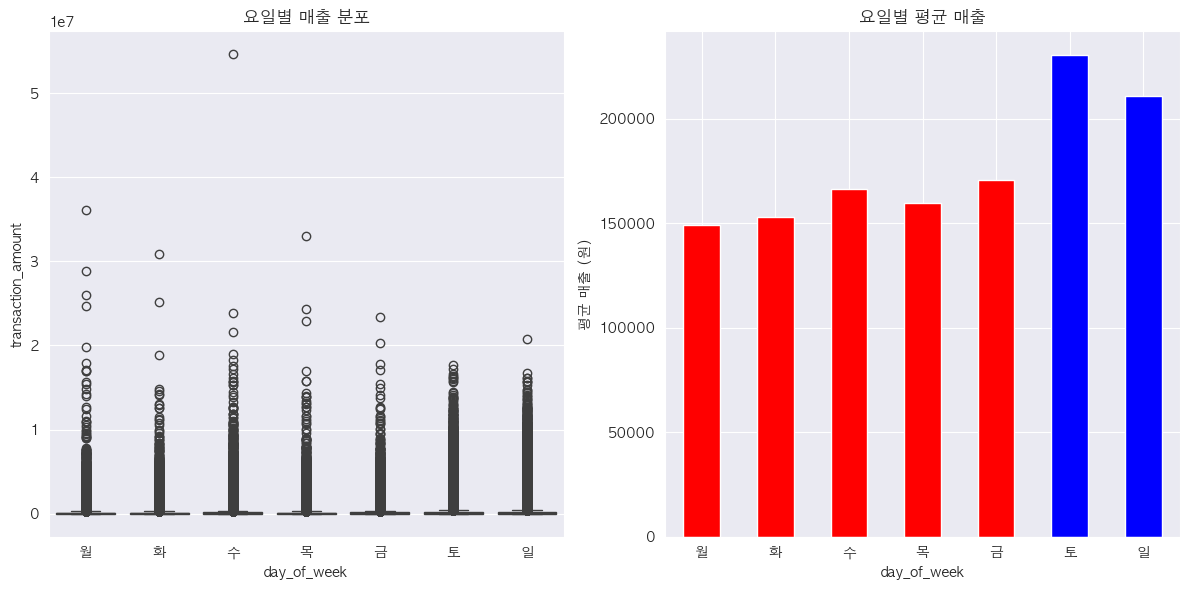

In [71]:
# 1-1. ÏöîÏùºÎ≥Ñ Îß§Ï∂ú Î∂ÑÌè¨ Î∞ïÏä§ÌîåÎ°Ø
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='day_of_week', y='transaction_amount')
plt.title('ÏöîÏùºÎ≥Ñ Îß§Ï∂ú Î∂ÑÌè¨')
plt.xticks(range(7), ['Ïõî', 'Ìôî', 'Ïàò', 'Î™©', 'Í∏à', 'ÌÜ†', 'Ïùº'])

# 1-2. ÏöîÏùºÎ≥Ñ ÌèâÍ∑† Îß§Ï∂ú ÎßâÎåÄÍ∑∏ÎûòÌîÑ
plt.subplot(1, 2, 2)
daily_avg = df.groupby('day_of_week')['transaction_amount'].mean()
daily_avg.plot(kind='bar', color=['red' if i < 5 else 'blue' for i in range(7)])
plt.title('ÏöîÏùºÎ≥Ñ ÌèâÍ∑† Îß§Ï∂ú')
plt.xticks(range(7), ['Ïõî', 'Ìôî', 'Ïàò', 'Î™©', 'Í∏à', 'ÌÜ†', 'Ïùº'], rotation=0)
plt.ylabel('ÌèâÍ∑† Îß§Ï∂ú (Ïõê)')
plt.tight_layout()
plt.show()

In [102]:
groups = [group['transaction_amount'].values for name, group in df.groupby('day_of_week')]
day_names = ['Ïõî', 'Ìôî', 'Ïàò', 'Î™©', 'Í∏à', 'ÌÜ†', 'Ïùº']

# Î™®Îì† ÏöîÏùº ÏåçÏóê ÎåÄÌï¥ t-Í≤ÄÏ†ï
for i, j in combinations(range(7), 2):
    t_stat, p_val = stats.ttest_ind(groups[i], groups[j])
    if p_val < 0.05:
        print(f'{day_names[i]}ÏöîÏùº vs {day_names[j]}ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p={p_val:.6f})')


ÏõîÏöîÏùº vs ÌôîÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000932)
ÏõîÏöîÏùº vs ÏàòÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏõîÏöîÏùº vs Î™©ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏõîÏöîÏùº vs Í∏àÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏõîÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏõîÏöîÏùº vs ÏùºÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs ÏàòÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs Î™©ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs Í∏àÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÌôîÏöîÏùº vs ÏùºÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏàòÏöîÏùº vs Î™©ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏàòÏöîÏùº vs Í∏àÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000388)
ÏàòÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
ÏàòÏöîÏùº vs ÏùºÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
Î™©ÏöîÏùº vs Í∏àÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
Î™©ÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
Î™©ÏöîÏùº vs ÏùºÏöîÏùº: Ïú†ÏùòÌïú Ï∞®Ïù¥ (p=0.000000)
Í∏àÏöîÏùº vs ÌÜ†ÏöîÏùº: Ïú†Ï

In [104]:
# Î∂ÑÏÇ∞ Î∂ÑÏÑù
f_stat, p_value = stats.f_oneway(*[group['transaction_amount'].values
                                   for name, group in df.groupby('day_of_week')])
print(f'F-statistic: {f_stat}, p-value: {p_value}')

F-statistic: 1061.2332676886479, p-value: 0.0


In [108]:
#ÌöåÍ∑Ä Î∂ÑÏÑù
df_regression = pd.get_dummies(df, columns=['day_of_week', 'gender', 'age_group_code', 'time_block_code'])

X = df_regression.drop(['transaction_amount', 'transaction_date', 'district_code', 'district_name'], axis=1)
y = df_regression['transaction_amount']


ÎèÖÎ¶ΩÎ≥ÄÏàò Í∞úÏàò: 36
ÏÉòÌîå Í∞úÏàò: 1603322
Ï£ºÏöî ÎèÖÎ¶ΩÎ≥ÄÏàòÎì§:
['transaction_count', 'avg_temp', 'max_temp', 'min_temp', 'amount_per_txn', 'temp_range', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4']


In [111]:
model = LinearRegression()
model.fit(X, y)

# ÏöîÏùº Î≥ÄÏàòÎì§Ïùò ÌöåÍ∑ÄÍ≥ÑÏàò Ï∂îÏ∂ú
day_coefficients = {}
for col in X.columns:
    if 'day_of_week' in col:
        coef_index = list(X.columns).index(col)
        day_coefficients[col] = model.coef_[coef_index]

print("ÏöîÏùºÎ≥Ñ ÌöåÍ∑ÄÍ≥ÑÏàò (Îã§Î•∏ Ï°∞Í±¥ ÎèôÏùºÌï† Îïå Îß§Ï∂ú Ï∞®Ïù¥):")
for day, coef in sorted(day_coefficients.items()):
    day_num = day.split('_')[-1]
    print(f"ÏöîÏùº {day_num}: {coef:,.0f}Ïõê")

ÏöîÏùºÎ≥Ñ ÌöåÍ∑ÄÍ≥ÑÏàò (Îã§Î•∏ Ï°∞Í±¥ ÎèôÏùºÌï† Îïå Îß§Ï∂ú Ï∞®Ïù¥):
ÏöîÏùº 1: -12,433Ïõê
ÏöîÏùº 2: -10,581Ïõê
ÏöîÏùº 3: -5,070Ïõê
ÏöîÏùº 4: -8,383Ïõê
ÏöîÏùº 5: -4,898Ïõê
ÏöîÏùº 6: 22,147Ïõê
ÏöîÏùº 7: 19,218Ïõê


In [112]:
X_no_day = X[[col for col in X.columns if 'day_of_week' not in col]]
model_no_day = LinearRegression()
model_no_day.fit(X_no_day, y)

# Î™®Îç∏ ÏÑ±Îä• ÎπÑÍµê
r2_full = model.score(X, y)        # ÏöîÏùº Ìè¨Ìï® Î™®Îç∏Ïùò ÏÑ§Î™ÖÎ†•
r2_no_day = model_no_day.score(X_no_day, y)  # ÏöîÏùº Ï†úÏô∏ Î™®Îç∏Ïùò ÏÑ§Î™ÖÎ†•

day_contribution = r2_full - r2_no_day

print(f"Ï†ÑÏ≤¥ Î™®Îç∏ ÏÑ§Î™ÖÎ†• (R¬≤): {r2_full:.4f}")
print(f"ÏöîÏùº Ï†úÏô∏ Î™®Îç∏ ÏÑ§Î™ÖÎ†• (R¬≤): {r2_no_day:.4f}")
print(f"ÏöîÏùº Î≥ÄÏàòÏùò ÏàúÏàò Í∏∞Ïó¨ÎèÑ: {day_contribution:.4f}")
print(f"ÏöîÏùº Î≥ÄÏàòÏùò Í∏∞Ïó¨ ÎπÑÏú®: {day_contribution/r2_full*100:.1f}%")

Ï†ÑÏ≤¥ Î™®Îç∏ ÏÑ§Î™ÖÎ†• (R¬≤): 0.4816
ÏöîÏùº Ï†úÏô∏ Î™®Îç∏ ÏÑ§Î™ÖÎ†• (R¬≤): 0.4807
ÏöîÏùº Î≥ÄÏàòÏùò ÏàúÏàò Í∏∞Ïó¨ÎèÑ: 0.0008
ÏöîÏùº Î≥ÄÏàòÏùò Í∏∞Ïó¨ ÎπÑÏú®: 0.2%


## "Ïó∞Î†πÎåÄÎ≥Ñ Îß§Ï∂ú ÏÜåÎπÑ ÏàòÏ§ÄÏóê Ï∞®Ïù¥Í∞Ä ÏóÜÎã§:

In [105]:
# 1-1. Ïó∞Î†πÎåÄ ÌòÑÌô© ÌååÏïÖ
print("1. Ïó∞Î†πÎåÄÎ≥Ñ Í∏∞Î≥∏ ÌòÑÌô©:")
age_counts = df['age_group_code'].value_counts().sort_index()
print("Ïó∞Î†πÎåÄÎ≥Ñ Í≥†Í∞ù Ïàò:")
for age_code, count in age_counts.items():
    percentage = count / len(df) * 100
    print(f"Ïó∞Î†πÎåÄ {age_code}: {count:,}Î™Ö ({percentage:.1f}%)")

1. Ïó∞Î†πÎåÄÎ≥Ñ Í∏∞Î≥∏ ÌòÑÌô©:
Ïó∞Î†πÎåÄÎ≥Ñ Í≥†Í∞ù Ïàò:
Ïó∞Î†πÎåÄ 1: 2Î™Ö (0.0%)
Ïó∞Î†πÎåÄ 2: 103,729Î™Ö (6.5%)
Ïó∞Î†πÎåÄ 3: 281,578Î™Ö (17.6%)
Ïó∞Î†πÎåÄ 4: 282,196Î™Ö (17.6%)
Ïó∞Î†πÎåÄ 5: 279,431Î™Ö (17.4%)
Ïó∞Î†πÎåÄ 6: 273,802Î™Ö (17.1%)
Ïó∞Î†πÎåÄ 7: 225,341Î™Ö (14.1%)
Ïó∞Î†πÎåÄ 8: 118,600Î™Ö (7.4%)
Ïó∞Î†πÎåÄ 9: 36,622Î™Ö (2.3%)
Ïó∞Î†πÎåÄ 10: 2,014Î™Ö (0.1%)
Ïó∞Î†πÎåÄ 11: 7Î™Ö (0.0%)


In [114]:
age_stats = df.groupby('age_group_code')['transaction_amount'].describe()
age_stats

count           mean            std     min       25%  \
age_group_code                                                             
1                    2.0    3363.500000    2544.877305  1564.0   2463.75   
2               103729.0   20834.771453   41762.472343    78.0   4693.00   
3               281578.0  177927.642781  349408.194838   152.0  18398.00   
4               282196.0  244193.144038  505541.735005    14.0  29881.00   
5               279431.0  271524.629579  661975.492036    94.0  32090.00   
6               273802.0  212304.141467  523778.331077   141.0  27901.00   
7               225341.0  103323.008520  298783.046045     0.0  14659.00   
8               118600.0   40996.321821  122840.893255    47.0   6884.00   
9                36622.0   25192.532822   81464.113400    16.0   5365.00   
10                2014.0   22399.358491   79064.077333   297.0   4693.00   
11                   7.0   45302.000000   76045.017869  8448.0  15488.00   

                    50%        75%         max  
age_group_code                                  
1                3363.5    4263.25      5163.0  
2                9800.0   22997.00   7571965.0  
3               55220.0  170953.75  17697419.0  
4               84861.0  244936.00  33031231.0  
5               95081.0  268371.50  54603977.0  
6               82654.0  213878.75  28823436.0  
7               39916.0   97677.00  16919934.0  
8               16270.0   36995.00   7826580.0  
9               11264.0   23467.00   4780976.0  
10               9387.0   20025.00   1815144.0  
11              18773.0   20729.00    217459.0

In [84]:
age_mean = df.groupby('age_group_code')['transaction_amount'].mean().sort_values(ascending=False)
for i, (age_code, avg_amount) in enumerate(age_mean.items(), 1):
    print(f"{i}ÏúÑ. Ïó∞Î†πÎåÄ {age_code}: {avg_amount:,.0f}Ïõê")

1ÏúÑ. Ïó∞Î†πÎåÄ 5: 271,525Ïõê
2ÏúÑ. Ïó∞Î†πÎåÄ 4: 244,193Ïõê
3ÏúÑ. Ïó∞Î†πÎåÄ 6: 212,304Ïõê
4ÏúÑ. Ïó∞Î†πÎåÄ 3: 177,928Ïõê
5ÏúÑ. Ïó∞Î†πÎåÄ 7: 103,323Ïõê
6ÏúÑ. Ïó∞Î†πÎåÄ 11: 45,302Ïõê
7ÏúÑ. Ïó∞Î†πÎåÄ 8: 40,996Ïõê
8ÏúÑ. Ïó∞Î†πÎåÄ 9: 25,193Ïõê
9ÏúÑ. Ïó∞Î†πÎåÄ 10: 22,399Ïõê
10ÏúÑ. Ïó∞Î†πÎåÄ 2: 20,835Ïõê
11ÏúÑ. Ïó∞Î†πÎåÄ 1: 3,364Ïõê


In [96]:
highest_age = age_mean.index[0]
lowest_age = age_mean.index[-1]
highest_amount = age_mean.iloc[0]
lowest_amount = age_mean.iloc[-1]

print(f"ÏµúÍ≥† ÏÜåÎπÑ: Ïó∞Î†πÎåÄ {highest_age} ({highest_amount:,.0f}Ïõê)")
print(f"ÏµúÏ†Ä ÏÜåÎπÑ: Ïó∞Î†πÎåÄ {lowest_age} ({lowest_amount:,.0f}Ïõê)")
print(f"Ï†àÎåÄ Ï∞®Ïù¥: {highest_amount - lowest_amount:,.0f}Ïõê")
print(f"ÏÉÅÎåÄ Ï∞®Ïù¥: {(highest_amount / lowest_amount - 1) * 100:.1f}%")

ÏµúÍ≥† ÏÜåÎπÑ: Ïó∞Î†πÎåÄ 5 (271,525Ïõê)
ÏµúÏ†Ä ÏÜåÎπÑ: Ïó∞Î†πÎåÄ 1 (3,364Ïõê)
Ï†àÎåÄ Ï∞®Ïù¥: 268,161Ïõê
ÏÉÅÎåÄ Ï∞®Ïù¥: 7972.7%


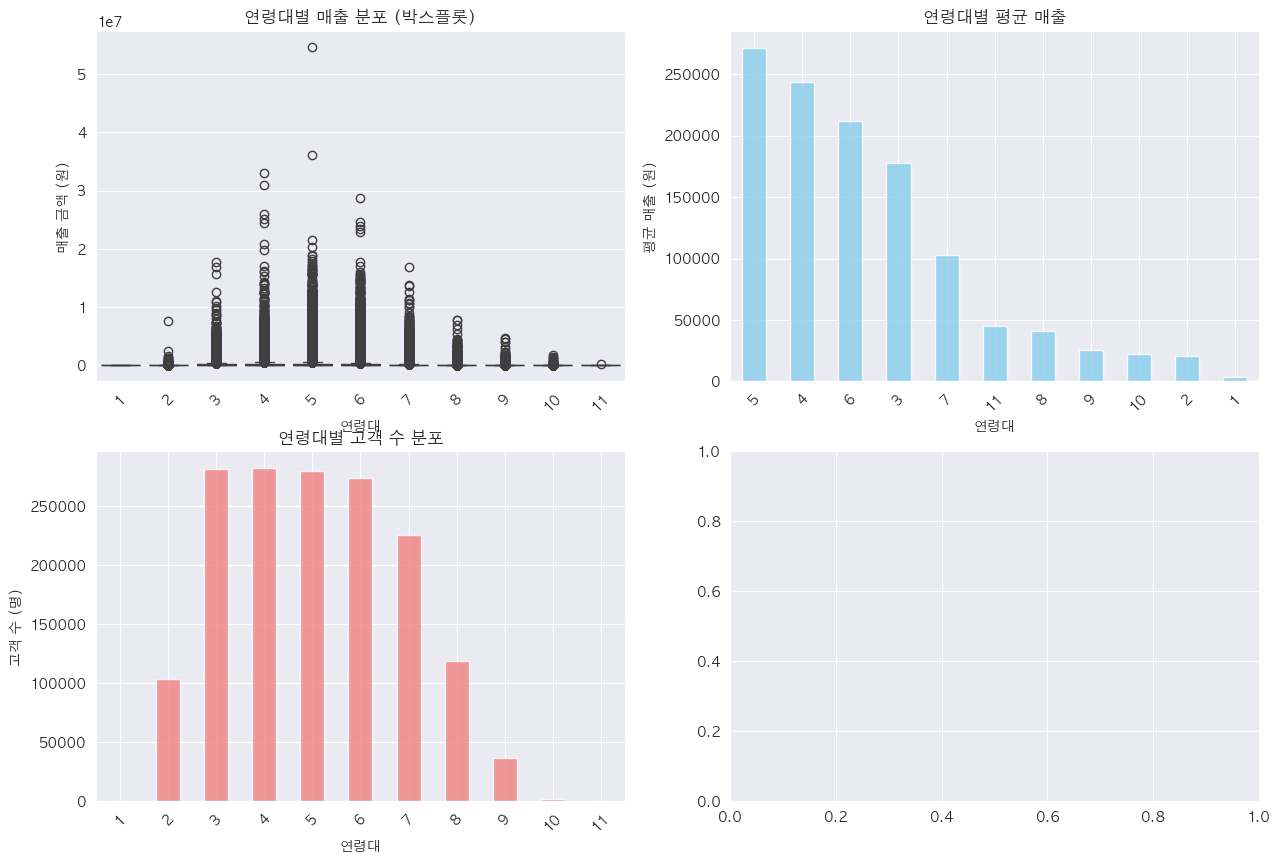

In [92]:
# 1-5. Ïó∞Î†πÎåÄÎ≥Ñ ÏÜåÎπÑ Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(2,2, figsize=(15, 10))

# Î∞ïÏä§ÌîåÎ°Ø - Ïó∞Î†πÎåÄÎ≥Ñ Îß§Ï∂ú Î∂ÑÌè¨
sns.boxplot(data=df, x='age_group_code', y='transaction_amount', ax=axes[0,0])
axes[0,0].set_title('Ïó∞Î†πÎåÄÎ≥Ñ Îß§Ï∂ú Î∂ÑÌè¨ (Î∞ïÏä§ÌîåÎ°Ø)')
axes[0,0].set_xlabel('Ïó∞Î†πÎåÄ')
axes[0,0].set_ylabel('Îß§Ï∂ú Í∏àÏï° (Ïõê)')
axes[0,0].tick_params(axis='x', rotation=45)

# ÎßâÎåÄÍ∑∏ÎûòÌîÑ - Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÍ∑† Îß§Ï∂ú
age_mean.plot(kind='bar', ax=axes[0,1], color='skyblue', alpha=0.8)
axes[0,1].set_title('Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÍ∑† Îß§Ï∂ú')
axes[0,1].set_xlabel('Ïó∞Î†πÎåÄ')
axes[0,1].set_ylabel('ÌèâÍ∑† Îß§Ï∂ú (Ïõê)')
axes[0,1].tick_params(axis='x', rotation=45)

# Í≥†Í∞ù Ïàò Î∂ÑÌè¨
age_counts.plot(kind='bar', ax=axes[1,0], color='lightcoral', alpha=0.8)
axes[1,0].set_title('Ïó∞Î†πÎåÄÎ≥Ñ Í≥†Í∞ù Ïàò Î∂ÑÌè¨')
axes[1,0].set_xlabel('Ïó∞Î†πÎåÄ')
axes[1,0].set_ylabel('Í≥†Í∞ù Ïàò (Î™Ö)')
axes[1,0].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [94]:
print("\n5. ÏÜåÎπÑ ÏàòÏ§ÄÎ≥Ñ Ïó∞Î†πÎåÄ Í∑∏Î£πÌôî:")
age_mean_sorted = age_mean.sort_values(ascending=False)
total_ages = len(age_mean_sorted)

# 3Îì±Î∂ÑÏúºÎ°ú Í∑∏Î£πÌôî
high_spenders = age_mean_sorted.iloc[:total_ages//3]
medium_spenders = age_mean_sorted.iloc[total_ages//3:2*total_ages//3]
low_spenders = age_mean_sorted.iloc[2*total_ages//3:]

print("Í≥†ÏÜåÎπÑÍµ∞ (ÏÉÅÏúÑ 1/3):")
for age_code, amount in high_spenders.items():
    print(f"  Ïó∞Î†πÎåÄ {age_code}: {amount:,.0f}Ïõê")

print("Ï§ëÍ∞ÑÏÜåÎπÑÍµ∞ (Ï§ëÏúÑ 1/3):")
for age_code, amount in medium_spenders.items():
    print(f"  Ïó∞Î†πÎåÄ {age_code}: {amount:,.0f}Ïõê")

print("Ï†ÄÏÜåÎπÑÍµ∞ (ÌïòÏúÑ 1/3):")
for age_code, amount in low_spenders.items():
    print(f"  Ïó∞Î†πÎåÄ {age_code}: {amount:,.0f}Ïõê")



5. ÏÜåÎπÑ ÏàòÏ§ÄÎ≥Ñ Ïó∞Î†πÎåÄ Í∑∏Î£πÌôî:
Í≥†ÏÜåÎπÑÍµ∞ (ÏÉÅÏúÑ 1/3):
  Ïó∞Î†πÎåÄ 5: 271,525Ïõê
  Ïó∞Î†πÎåÄ 4: 244,193Ïõê
  Ïó∞Î†πÎåÄ 6: 212,304Ïõê
Ï§ëÍ∞ÑÏÜåÎπÑÍµ∞ (Ï§ëÏúÑ 1/3):
  Ïó∞Î†πÎåÄ 3: 177,928Ïõê
  Ïó∞Î†πÎåÄ 7: 103,323Ïõê
  Ïó∞Î†πÎåÄ 11: 45,302Ïõê
  Ïó∞Î†πÎåÄ 8: 40,996Ïõê
Ï†ÄÏÜåÎπÑÍµ∞ (ÌïòÏúÑ 1/3):
  Ïó∞Î†πÎåÄ 9: 25,193Ïõê
  Ïó∞Î†πÎåÄ 10: 22,399Ïõê
  Ïó∞Î†πÎåÄ 2: 20,835Ïõê
  Ïó∞Î†πÎåÄ 1: 3,364Ïõê


In [97]:
cv_age = df.groupby('age_group_code')['transaction_amount'].agg(['mean', 'std'])
cv_age['cv'] = cv_age['std'] / cv_age['mean']
avg_cv = cv_age['cv'].mean()

if (highest_amount / lowest_amount) > 1.5:  # 50% Ïù¥ÏÉÅ Ï∞®Ïù¥
    print("Í∞ÄÏÑ§ Í∏∞Í∞Å Í∞ÄÎä•ÏÑ± ÎÜíÏùå - Ïó∞Î†πÎåÄÎ≥Ñ ÎöúÎ†∑Ìïú ÏÜåÎπÑ Ï∞®Ïù¥ Í¥ÄÏ∞∞")
elif (highest_amount / lowest_amount) > 1.2:  # 20% Ïù¥ÏÉÅ Ï∞®Ïù¥
    print("Í∞ÄÏÑ§ Í∏∞Í∞Å Í∞ÄÎä•ÏÑ± ÏûàÏùå - Ïó∞Î†πÎåÄÎ≥Ñ Ï§ëÍ∞Ñ Ï†ïÎèÑ Ï∞®Ïù¥ Í¥ÄÏ∞∞")
else:
    print("Í∞ÄÏÑ§ Ï±ÑÌÉù Í∞ÄÎä•ÏÑ± ÏûàÏùå - Ïó∞Î†πÎåÄÎ≥Ñ Ï∞®Ïù¥Í∞Ä ÎØ∏ÎØ∏")

print(f"ÏµúÎåÄ Ïó∞Î†πÎåÄ Í∞Ñ Ï∞®Ïù¥: {(highest_amount / lowest_amount - 1) * 100:.1f}%")
print(f"Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÍ∑† Î≥ÄÎèôÍ≥ÑÏàò: {avg_cv:.2f}")

Í∞ÄÏÑ§ Í∏∞Í∞Å Í∞ÄÎä•ÏÑ± ÎÜíÏùå - Ïó∞Î†πÎåÄÎ≥Ñ ÎöúÎ†∑Ìïú ÏÜåÎπÑ Ï∞®Ïù¥ Í¥ÄÏ∞∞
ÏµúÎåÄ Ïó∞Î†πÎåÄ Í∞Ñ Ï∞®Ïù¥: 7972.7%
Ïó∞Î†πÎåÄÎ≥Ñ ÌèâÍ∑† Î≥ÄÎèôÍ≥ÑÏàò: 2.37


In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Î≥ÄÏàò ÏÑ†ÌÉù
features = ['age_group_code', 'gender']  # ÌïÑÏöîÏãú Ï∂îÍ∞Ä
X = df[features]
y = df['transaction_amount']

# Î≤îÏ£ºÌòï Ïù∏ÏΩîÎî©
X = pd.get_dummies(X, columns=['age_group_code', 'gender'], drop_first=True)

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Î™®Îç∏ ÌõàÎ†®
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ÏòàÏ∏°
y_pred = model.predict(X_test)

# ÌèâÍ∞Ä
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.0f}Ïõê")
print(f"RMSE: {rmse:,.0f}Ïõê")
print(f"R¬≤ Score: {r2:.4f}")

MAE: 187,102Ïõê
RMSE: 445,926Ïõê
R¬≤ Score: 0.0330


In [33]:
# 1. ÏÉòÌîåÎßÅÏúºÎ°ú Îπ†Î•∏ ÌÖåÏä§Ìä∏ (10% ÏÉòÌîå)
df_sample = df.sample(n=50000, random_state=42)  # 5ÎßåÍ∞ú ÏÉòÌîå
print(f"ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {df_sample.shape}")

# 2. Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨
df_sample['transaction_date'] = pd.to_datetime(df_sample['transaction_date'])
df_sample['year'] = df_sample['transaction_date'].dt.year
df_sample['month'] = df_sample['transaction_date'].dt.month
df_sample['day'] = df_sample['transaction_date'].dt.day

# ÏÑ±Î≥Ñ ÏõêÌï´ Ïù∏ÏΩîÎî©
df_encoded = pd.get_dummies(df_sample, columns=['gender'])

# 3. Í∞ÑÎã®Ìïú ÌäπÏÑ±Îßå ÏÇ¨Ïö© (ÌîºÏ≤ò ÏóîÏßÄÎãàÏñ¥ÎßÅ Ï†úÏô∏)
X = df_encoded[['gender_F', 'gender_M', 'age_group_code',
                'time_block_code', 'day_of_week', 'avg_temp', 'district_code',
                'year', 'month', 'day']]
y = df_encoded['transaction_amount']

print("Í∏∞Î≥∏ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë...")

# 4. Î™®Îç∏ ÌõàÎ†® (Îπ†Î•∏ ÏÑ§Ï†ï)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Í∞ÑÎã®Ìïú Î™®Îç∏Îì§ ÎπÑÍµê
models = {
    'RandomForest_Small': RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    'RandomForest_Medium': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"{name} ÌõàÎ†® Ï§ë...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name} ÏôÑÎ£å!")

# 5. Í≤∞Í≥º Ï∂úÎ†•
print("\n=== ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Î™®Îç∏ ÏÑ±Îä• ===")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  RMSE: {metrics['RMSE']:,.2f}")
    print(f"  R¬≤: {metrics['R2']:.4f}")
    print(f"  ÏÑ§Î™ÖÎ†•: {metrics['R2']*100:.2f}%")
    print()

print("\n‚úÖ ÏÉòÌîå ÌÖåÏä§Ìä∏ ÏôÑÎ£å!")
print("ÏÑ±Îä•Ïù¥ ÎßåÏ°±Ïä§ÎüΩÎã§Î©¥ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î°ú ÌôïÏû•ÌïòÏÑ∏Ïöî.")

ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (50000, 18)
Í∏∞Î≥∏ Î™®Îç∏ ÌõàÎ†® ÏãúÏûë...
RandomForest_Small ÌõàÎ†® Ï§ë...
RandomForest_Small ÏôÑÎ£å!
RandomForest_Medium ÌõàÎ†® Ï§ë...
RandomForest_Medium ÏôÑÎ£å!

=== ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Î™®Îç∏ ÏÑ±Îä• ===
RandomForest_Small:
  RMSE: 428,676.70
  R¬≤: 0.1066
  ÏÑ§Î™ÖÎ†•: 10.66%

RandomForest_Medium:
  RMSE: 462,833.51
  R¬≤: -0.0414
  ÏÑ§Î™ÖÎ†•: -4.14%


‚úÖ ÏÉòÌîå ÌÖåÏä§Ìä∏ ÏôÑÎ£å!
ÏÑ±Îä•Ïù¥ ÎßåÏ°±Ïä§ÎüΩÎã§Î©¥ Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î°ú ÌôïÏû•ÌïòÏÑ∏Ïöî.


In [37]:
# Íµ¨Îß§ Ìå®ÌÑ¥ Î∂ÑÏÑù Î∞è ÏòàÏ∏° ÏòµÏÖò
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("üîÑ Î¨∏Ï†ú Ïû¨Ï†ïÏùò: Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù Î∞è ÏòàÏ∏° ÏòµÏÖò ÌÉêÏÉâ")
print("="*60)

# 1. ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ Î∂ÑÏÑù
print("üìä 1. ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ Î∂ÑÏÑù")
print("-" * 30)
print(f"Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {df.shape}")
print(f"Ïª¨ÎüºÎì§: {list(df.columns)}")
print()

# Ï£ºÏöî Î≥ÄÏàòÎì§Ïùò Î∂ÑÌè¨ ÌôïÏù∏
print("Ï£ºÏöî Î≥ÄÏàò Î∂ÑÌè¨:")
print(f"Í±∞ÎûòÍ∏àÏï° Î≤îÏúÑ: {df['transaction_amount'].min():,}Ïõê ~ {df['transaction_amount'].max():,}Ïõê")
print(f"Í±∞ÎûòÌöüÏàò Î≤îÏúÑ: {df['transaction_count'].min()} ~ {df['transaction_count'].max()}Ìöå")
print(f"ÏÑ±Î≥Ñ Î∂ÑÌè¨:\n{df['gender'].value_counts()}")
print(f"Ïó∞Î†πÎåÄ Î∂ÑÌè¨:\n{df['age_group_code'].value_counts().sort_index()}")
print(f"ÏßÄÏó≠ Î∂ÑÌè¨:\n{df['district_code'].value_counts().head()}")

# 2. ÏòàÏ∏° Í∞ÄÎä•Ìïú Î¨∏Ï†úÎì§ Ï†ïÏùò
print(f"\n" + "="*60)
print("üéØ 2. ÏòàÏ∏° Í∞ÄÎä•Ìïú Î¨∏Ï†úÎì§ Ï†ïÏùò")
print("="*60)

# 2-1. Í≥†Ïï° Íµ¨Îß§ Ïó¨Î∂Ä ÏòàÏ∏° (Ïù¥ÏßÑ Î∂ÑÎ•ò)
threshold_high = df['transaction_amount'].quantile(0.7)  # ÏÉÅÏúÑ 30%
df['is_high_spender'] = (df['transaction_amount'] >= threshold_high).astype(int)

print(f"üí∞ Î¨∏Ï†ú 1: Í≥†Ïï° Íµ¨Îß§ ÏòàÏ∏° (Ïù¥ÏßÑ Î∂ÑÎ•ò)")
print(f"  Í∏∞Ï§Ä: {threshold_high:,.0f}Ïõê Ïù¥ÏÉÅ")
print(f"  Í≥†Ïï° Íµ¨Îß§Ïûê: {df['is_high_spender'].sum():,}Î™Ö ({df['is_high_spender'].mean()*100:.1f}%)")

# 2-2. Íµ¨Îß§ Í∏àÏï°ÎåÄ ÏòàÏ∏° (Îã§Ï§ë Î∂ÑÎ•ò)
df['amount_category'] = pd.cut(df['transaction_amount'],
                              bins=[0, 20000, 50000, 100000, 200000, float('inf')],
                              labels=['ÏÜåÏï°(~2Îßå)', 'ÏùºÎ∞ò(2-5Îßå)', 'Ï§ëÏï°(5-10Îßå)', 'Í≥†Ïï°(10-20Îßå)', 'ÌäπÍ≥†Ïï°(20Îßå+)'])

print(f"\nüí≥ Î¨∏Ï†ú 2: Íµ¨Îß§ Í∏àÏï°ÎåÄ ÏòàÏ∏° (5Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨)")
print("Í∏àÏï°ÎåÄÎ≥Ñ Î∂ÑÌè¨:")
print(df['amount_category'].value_counts().sort_index())

# 2-3. Îã§Ï§ë Íµ¨Îß§ Ïó¨Î∂Ä ÏòàÏ∏° (Ïù¥ÏßÑ Î∂ÑÎ•ò)
df['is_multiple_purchase'] = (df['transaction_count'] > 1).astype(int)

print(f"\nüõí Î¨∏Ï†ú 3: Îã§Ï§ë Íµ¨Îß§ Ïó¨Î∂Ä ÏòàÏ∏° (Ïù¥ÏßÑ Î∂ÑÎ•ò)")
print(f"  Îã§Ï§ë Íµ¨Îß§Ïûê: {df['is_multiple_purchase'].sum():,}Î™Ö ({df['is_multiple_purchase'].mean()*100:.1f}%)")

# 2-4. Íµ¨Îß§ ÎπàÎèÑ Ïπ¥ÌÖåÍ≥†Î¶¨ ÏòàÏ∏° (Îã§Ï§ë Î∂ÑÎ•ò)
df['purchase_frequency'] = pd.cut(df['transaction_count'],
                                 bins=[0, 1, 2, 3, float('inf')],
                                 labels=['Îã®ÏùºÍµ¨Îß§', 'Ï†ÅÏùå(2Ìöå)', 'Î≥¥ÌÜµ(3Ìöå)', 'ÎßéÏùå(4Ìöå+)'])

print(f"\nüìà Î¨∏Ï†ú 4: Íµ¨Îß§ ÎπàÎèÑ ÏòàÏ∏° (4Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨)")
print("Íµ¨Îß§ ÎπàÎèÑÎ≥Ñ Î∂ÑÌè¨:")
print(df['purchase_frequency'].value_counts().sort_index())

# 2-5. ÏãúÍ∞ÑÎåÄÎ≥Ñ Íµ¨Îß§ Ìå®ÌÑ¥ ÏòàÏ∏°
peak_hours = [5, 6, 7]  # Ï†ÄÎÖÅ ÏãúÍ∞ÑÎåÄ
df['is_peak_time_buyer'] = df['time_block_code'].isin(peak_hours).astype(int)

print(f"\n‚è∞ Î¨∏Ï†ú 5: ÌîºÌÅ¨ ÏãúÍ∞ÑÎåÄ Íµ¨Îß§ ÏòàÏ∏° (Ïù¥ÏßÑ Î∂ÑÎ•ò)")
print(f"  ÌîºÌÅ¨ÏãúÍ∞Ñ Íµ¨Îß§Ïûê: {df['is_peak_time_buyer'].sum():,}Î™Ö ({df['is_peak_time_buyer'].mean()*100:.1f}%)")

# 3. Í∞Å Î¨∏Ï†úÎ≥Ñ ÏòàÏ∏° ÏÑ±Îä• ÌÖåÏä§Ìä∏
print(f"\n" + "="*60)
print("üî¨ 3. Í∞Å Î¨∏Ï†úÎ≥Ñ ÏòàÏ∏° ÏÑ±Îä• Îπ†Î•∏ ÌÖåÏä§Ìä∏")
print("="*60)

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞Î°ú Îπ†Î•∏ ÌÖåÏä§Ìä∏
df_sample = df.sample(n=50000, random_state=42)

# Í∏∞Î≥∏ ÌäπÏÑ±Îì§ Ï§ÄÎπÑ
basic_features = ['gender', 'age_group_code', 'time_block_code', 'day_of_week', 'avg_temp', 'district_code']
X_basic = pd.get_dummies(df_sample[basic_features], drop_first=True)

# Í∞Å ÏòàÏ∏° Î¨∏Ï†úÎ≥Ñ ÏÑ±Îä• ÌÖåÏä§Ìä∏
problems = {
    'Í≥†Ïï° Íµ¨Îß§ ÏòàÏ∏°': df_sample['is_high_spender'],
    'Íµ¨Îß§ Í∏àÏï°ÎåÄ ÏòàÏ∏°': df_sample['amount_category'],
    'Îã§Ï§ë Íµ¨Îß§ ÏòàÏ∏°': df_sample['is_multiple_purchase'],
    'Íµ¨Îß§ ÎπàÎèÑ ÏòàÏ∏°': df_sample['purchase_frequency'],
    'ÌîºÌÅ¨ÏãúÍ∞Ñ Íµ¨Îß§ ÏòàÏ∏°': df_sample['is_peak_time_buyer']
}

results = {}
for problem_name, y_target in problems.items():
    # Í≤∞Ï∏°Í∞í Ï†úÍ±∞
    valid_idx = y_target.notna()
    X_clean = X_basic[valid_idx]
    y_clean = y_target[valid_idx]

    # ÎùºÎ≤® Ïù∏ÏΩîÎî© (Îã§Ï§ë Î∂ÑÎ•òÏö©)
    if y_clean.dtype == 'object' or y_clean.dtype.name == 'category':
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_clean.astype(str))
        is_multiclass = True
        n_classes = len(le.classes_)
    else:
        y_encoded = y_clean
        is_multiclass = False
        n_classes = 2

    # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Î™®Îç∏ ÌõàÎ†®
    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # AUC Í≥ÑÏÇ∞ (Ïù¥ÏßÑ Î∂ÑÎ•òÏù¥Í≥† ÌÅ¥ÎûòÏä§Í∞Ä 2Í∞úÏù∏ Í≤ΩÏö∞Îßå)
        if n_classes == 2 and len(model.classes_) == 2:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
        else:
            auc = "N/A"

    except Exception as e:
        print(f"  ‚ö†Ô∏è Î™®Îç∏ ÌõàÎ†® Ïò§Î•ò: {str(e)}")
        accuracy = 0.0
        auc = "Error"

    results[problem_name] = {
        'accuracy': accuracy,
        'auc': auc,
        'n_classes': n_classes,
        'baseline': max(np.bincount(y_encoded)) / len(y_encoded),  # ÏµúÎπàÍ∞í ÏòàÏ∏° Í∏∞Ï§Ä
        'sample_size': len(y_encoded)
    }

    print(f"\nüìä {problem_name}:")
    print(f"  Ï†ïÌôïÎèÑ: {accuracy:.3f}")
    print(f"  AUC: {auc}")
    print(f"  ÌÅ¥ÎûòÏä§ Ïàò: {n_classes}")
    print(f"  ÏÉòÌîå Ïàò: {results[problem_name]['sample_size']:,}")
    print(f"  Î≤†Ïù¥Ïä§ÎùºÏù∏: {results[problem_name]['baseline']:.3f}")

    # Î≤†Ïù¥Ïä§ÎùºÏù∏ ÎåÄÎπÑ Í∞úÏÑ†ÎèÑ
    if accuracy > 0:
        improvement = (accuracy - results[problem_name]['baseline']) / results[problem_name]['baseline'] * 100
        print(f"  Í∞úÏÑ†ÎèÑ: +{improvement:.1f}%")
    else:
        print(f"  Í∞úÏÑ†ÎèÑ: Í≥ÑÏÇ∞ Î∂àÍ∞Ä")

# 4. Í∂åÏû• Î¨∏Ï†ú ÏÑ†ÌÉù
print(f"\n" + "="*60)
print("üéØ 4. Í∂åÏû• Î¨∏Ï†ú ÏÑ†ÌÉù Î∞è Í∑ºÍ±∞")
print("="*60)

# ÏÑ±Îä• Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÎ†¨
sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

print("ÏÑ±Îä• ÏàúÏúÑ:")
for i, (problem, result) in enumerate(sorted_results, 1):
    if result['accuracy'] > 0:
        improvement = (result['accuracy'] - result['baseline']) / result['baseline'] * 100
        print(f"{i}. {problem}")
        print(f"   Ï†ïÌôïÎèÑ: {result['accuracy']:.3f} (Î≤†Ïù¥Ïä§ÎùºÏù∏ ÎåÄÎπÑ +{improvement:.1f}%)")
        if result['auc'] not in ["N/A", "Error"] and isinstance(result['auc'], float):
            print(f"   AUC: {result['auc']:.3f}")
        print()

# 5. ÎπÑÏ¶àÎãàÏä§ Í¥ÄÏ†êÏóêÏÑúÏùò Í∞ÄÏπò ÌèâÍ∞Ä
print("üíº ÎπÑÏ¶àÎãàÏä§ Í¥ÄÏ†êÏóêÏÑúÏùò Í∞ÄÏπò:")

business_value = {
    'Í≥†Ïï° Íµ¨Îß§ ÏòàÏ∏°': {
        'value': 'ÎÜíÏùå',
        'use_cases': ['VIP Í≥†Í∞ù Í¥ÄÎ¶¨', 'Í∞úÏù∏Ìôî ÎßàÏºÄÌåÖ', 'Îß§Ï∂ú ÏßëÏ§ë Í¥ÄÎ¶¨'],
        'impact': 'ÏßÅÏ†ëÏ†ÅÏù∏ Îß§Ï∂ú Ï¶ùÎåÄ'
    },
    'Îã§Ï§ë Íµ¨Îß§ ÏòàÏ∏°': {
        'value': 'ÎÜíÏùå',
        'use_cases': ['ÍµêÏ∞® ÌåêÎß§', 'ÏÉÅÌíà Ï∂îÏ≤ú', 'Îß§Ïû• Î∞∞Ïπò ÏµúÏ†ÅÌôî'],
        'impact': 'Íµ¨Îß§Îüâ Ï¶ùÍ∞Ä'
    },
    'ÌîºÌÅ¨ÏãúÍ∞Ñ Íµ¨Îß§ ÏòàÏ∏°': {
        'value': 'Ï§ëÍ∞Ñ',
        'use_cases': ['Ïù∏Î†• Î∞∞Ïπò', 'Ïû¨Í≥† Í¥ÄÎ¶¨', 'ÌîÑÎ°úÎ™®ÏÖò ÌÉÄÏù¥Î∞ç'],
        'impact': 'Ïö¥ÏòÅ Ìö®Ïú®ÏÑ±'
    },
    'Íµ¨Îß§ Í∏àÏï°ÎåÄ ÏòàÏ∏°': {
        'value': 'Ï§ëÍ∞Ñ',
        'use_cases': ['ÏÉÅÌíà ÏßÑÏó¥', 'Í∞ÄÍ≤© Ï†ÑÎûµ', 'Í≥†Í∞ù ÏÑ∏Î∂ÑÌôî'],
        'impact': 'Ï†ÑÎûµÏ†Å ÏùòÏÇ¨Í≤∞Ï†ï'
    },
    'Íµ¨Îß§ ÎπàÎèÑ ÏòàÏ∏°': {
        'value': 'Ï§ëÍ∞Ñ',
        'use_cases': ['Ï∂©ÏÑ±ÎèÑ ÌîÑÎ°úÍ∑∏Îû®', 'Î¶¨ÌÖêÏÖò Í¥ÄÎ¶¨', 'Ïû¨Î∞©Î¨∏ Ïú†ÎèÑ'],
        'impact': 'Í≥†Í∞ù ÏÉùÏï†Í∞ÄÏπò'
    }
}

for problem, info in business_value.items():
    print(f"\n{problem}:")
    print(f"  Í∞ÄÏπò: {info['value']}")
    print(f"  ÌôúÏö© ÏÇ¨Î°Ä: {', '.join(info['use_cases'])}")
    print(f"  ÎπÑÏ¶àÎãàÏä§ ÏûÑÌå©Ìä∏: {info['impact']}")

# 6. ÏµúÏ¢Ö Í∂åÏû•ÏÇ¨Ìï≠
print(f"\n" + "="*60)
print("üèÜ ÏµúÏ¢Ö Í∂åÏû•ÏÇ¨Ìï≠")
print("="*60)

# ÏÑ±Îä•Í≥º ÎπÑÏ¶àÎãàÏä§ Í∞ÄÏπòÎ•º Ï¢ÖÌï©Ìïú Í∂åÏû•
top_problem = sorted_results[0][0]
print(f"ü•á 1ÏàúÏúÑ Í∂åÏû•: {top_problem}")
print(f"   Ïù¥Ïú†: Í∞ÄÏû• ÎÜíÏùÄ ÏòàÏ∏° Ï†ïÌôïÎèÑ ({sorted_results[0][1]['accuracy']:.3f})")

print(f"\nüí° Îã§Ïùå Îã®Í≥Ñ:")
print(f"1. '{top_problem}' Î¨∏Ï†úÎ°ú ÏÉÅÏÑ∏ Î™®Îç∏ÎßÅ ÏßÑÌñâ")
print(f"2. ÌäπÏÑ± ÏóîÏßÄÎãàÏñ¥ÎßÅÏúºÎ°ú ÏÑ±Îä• Ï∂îÍ∞Ä Í∞úÏÑ†")
print(f"3. ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù")
print(f"4. Ïã§Ï†ú ÎπÑÏ¶àÎãàÏä§ Ï†ÅÏö© ÌÖåÏä§Ìä∏")

print(f"\nÏñ¥Îñ§ Î¨∏Ï†úÎ•º ÏÑ†ÌÉùÌïòÏãúÍ≤†ÏäµÎãàÍπå?")
print(f"Í∂åÏû•: {top_problem} (Ï†ïÌôïÎèÑ {sorted_results[0][1]['accuracy']:.3f})")

üîÑ Î¨∏Ï†ú Ïû¨Ï†ïÏùò: Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù Î∞è ÏòàÏ∏° ÏòµÏÖò ÌÉêÏÉâ
üìä 1. ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ Î∂ÑÏÑù
------------------------------
Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (1603322, 18)
Ïª¨ÎüºÎì§: ['transaction_date', 'district_code', 'district_name', 'time_block_code', 'gender', 'age_group_code', 'day_of_week', 'transaction_amount', 'transaction_count', 'avg_temp', 'year', 'month', 'day', 'is_high_spender', 'amount_category', 'is_multiple_purchase', 'purchase_frequency', 'is_peak_time_buyer']

Ï£ºÏöî Î≥ÄÏàò Î∂ÑÌè¨:
Í±∞ÎûòÍ∏àÏï° Î≤îÏúÑ: 0Ïõê ~ 54,603,977Ïõê
Í±∞ÎûòÌöüÏàò Î≤îÏúÑ: 2 ~ 1009Ìöå
ÏÑ±Î≥Ñ Î∂ÑÌè¨:
gender
M    830039
F    773283
Name: count, dtype: int64
Ïó∞Î†πÎåÄ Î∂ÑÌè¨:
age_group_code
1          2
2     103729
3     281578
4     282196
5     279431
6     273802
7     225341
8     118600
9      36622
10      2014
11         7
Name: count, dtype: int64
ÏßÄÏó≠ Î∂ÑÌè¨:
district_code
41117    458725
41113    425788
41111    374284
41115    344525
Name: count, dtype: int64

üéØ 2. ÏòàÏ∏° Í∞ÄÎä•Ìïú Î¨∏